In [1]:
import torch

from botorch.utils.sampling import draw_sobol_samples

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import SimplexWeight, UnitVector
from scalarize.test_functions.multi_objective import FourBarTrussDesign

import matplotlib
from matplotlib.ticker import FixedFormatter
import matplotlib.lines as mlines
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
input_dim = 4
output_dim = 2

problem = FourBarTrussDesign(negate=True)
bounds = problem.bounds.to(**tkwargs)

# Get a batch of random samples.
torch.manual_seed(0)
num_samples = 128
grid_length = 32
num_points = grid_length * grid_length

b1 = torch.column_stack([bounds[:, 0], bounds[:, 2]])
b2 = torch.column_stack([bounds[:, 1], bounds[:, 3]])

g1 = torch.linspace(b1[0, 0], b1[1, 0], grid_length).to(**tkwargs)
g2 = torch.linspace(b1[0, 1], b1[1, 1], grid_length).to(**tkwargs)
X, Y = torch.meshgrid(g1, g2, indexing="xy")

X1 = []
for i in range(grid_length):
    X1 += [torch.column_stack([X[i, :], Y[i, :]])]
X1 = torch.cat(X1)
X2 = draw_sobol_samples(bounds=b2, n=num_samples, q=1, seed=2).squeeze(-2)

Ys = torch.zeros(num_samples, num_points, output_dim, **tkwargs)
Xs = torch.zeros(num_samples, num_points, input_dim, **tkwargs)
ones = torch.ones(num_points, 1, **tkwargs)

for n in range(num_samples):
    Xn = torch.column_stack(
        [
            X1[:, 0],
            X2[n, 0] * ones,
            X1[:, 1],
            X2[n, 1] * ones,
        ]
    )
    Yn = problem(Xn)

    Xs[n, ...] = Xn
    Ys[n, ...] = Yn

# Get the lengths.
num_weights = 201
nadir = 0 * torch.ones(1, output_dim, **tkwargs)
t = torch.linspace(0, 1, num_weights, **tkwargs).unsqueeze(-1)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
scalarization_fn = LengthScalarization(weights=weights, ref_points=nadir)

# Get the Pareto fronts.
rescaled_Ys = torch.zeros(num_samples, num_points, output_dim, **tkwargs)
lengths = torch.zeros(num_samples, num_weights, **tkwargs)
fronts = torch.zeros(num_samples, num_weights, output_dim, **tkwargs)
for n in range(num_samples):
    # Rescale objective vectors to lie in the unit hypercube.
    Yn = torch.column_stack(
        [(Ys[n][:, 0] + 1400) / 1400 + 0.925, (Ys[n][:, 1] + 0.005) / 0.04 + 0.95]
    )
    lengths[n, :] = scalarization_fn(Yn).max(dim=0).values
    rescaled_Ys[n, ...] = Yn
    fronts[n, ...] = nadir + weights * lengths[n, :].unsqueeze(-1)

In [3]:
# Mean.
mean_front = nadir + weights * lengths.mean(dim=0).unsqueeze(-1)

num_bootstrap = 128
simplex_transform = SimplexWeight(
    num_objectives=num_samples, transform_label="log_normalize"
)
u = torch.rand(num_bootstrap, num_samples, **tkwargs)
simplex_weights = simplex_transform(u).unsqueeze(-1)

bootstrap_mean_fronts = nadir + weights * (simplex_weights * lengths).sum(
    dim=-2
).unsqueeze(-1)
bootstrap_expected_front = nadir + weights * (simplex_weights * lengths).sum(
    dim=-2
).mean(dim=0).unsqueeze(-1)

# Get contour colours.
betas = [0.5, 1.0, 1.5, 2.0]
variance_colors = pl.cm.viridis(torch.linspace(0, 1, len(betas)))

qs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
quantile_colors = pl.cm.viridis(torch.linspace(0, 1, len(qs)))


cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "custom_cmap", cmaplist, cmap.N
)

# Define the bins and normalize.
variance_bounds = torch.linspace(1 / len(betas), len(betas) + 1, len(betas) + 1)
variance_norm = matplotlib.colors.BoundaryNorm(variance_bounds, cmap.N)

quantile_bounds = torch.linspace(1 / len(qs), len(qs) + 1, len(qs) + 1)
quantile_norm = matplotlib.colors.BoundaryNorm(quantile_bounds, cmap.N)

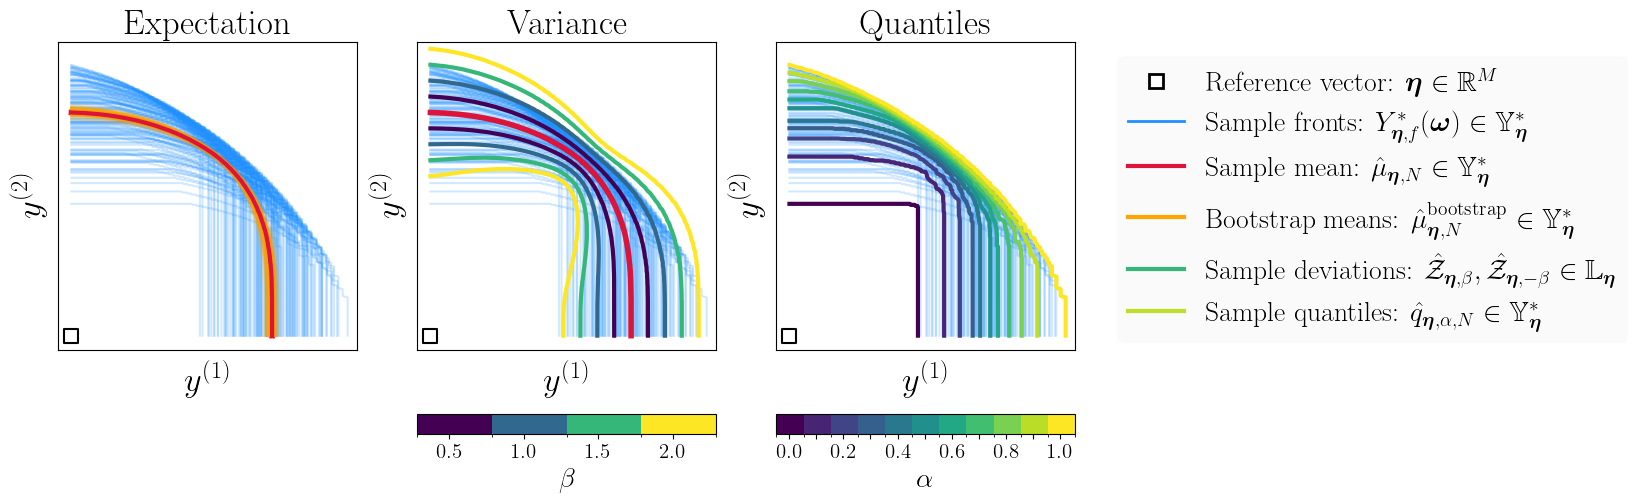

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(13.125, 4))

for i in range(3):
    ax = plt.subplot(1, 3, i + 1)

    for n in range(num_samples):
        ax.plot(fronts[n, :, 0], fronts[n, :, 1], color="dodgerblue", alpha=0.2)

    ax.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$y^{(1)}$", fontsize=25)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=25)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
####################################################################################
# Expectation.
ax = plt.subplot(1, 3, 1)
ax.plot(mean_front[:, 0], mean_front[:, 1], color="crimson", alpha=1, linewidth=4)

for b in range(num_bootstrap):
    ax.plot(
        bootstrap_mean_fronts[b, :, 0],
        bootstrap_mean_fronts[b, :, 1],
        color="orange",
        alpha=0.1,
        linewidth=2,
        zorder=5,
    )
ax.plot(
    mean_front[:, 0], mean_front[:, 1], color="crimson", alpha=1, linewidth=3, zorder=6
)

ax.set_title("Expectation", fontsize=25)
####################################################################################
# Variance.
ax = plt.subplot(1, 3, 2)
mean_lengths = lengths.mean(dim=0)
std_lengths = lengths.std(dim=0)

for i, beta in enumerate(betas):
    deviation_front = nadir + weights * (mean_lengths + beta * std_lengths).unsqueeze(
        -1
    )
    ax.plot(
        deviation_front[:, 0],
        deviation_front[:, 1],
        alpha=1,
        color=variance_colors[i],
        linewidth=3,
    )

    deviation_front = nadir + weights * (mean_lengths - beta * std_lengths).unsqueeze(
        -1
    )
    ax.plot(
        deviation_front[:, 0],
        deviation_front[:, 1],
        alpha=1,
        color=variance_colors[i],
        linewidth=3,
    )

ax.plot(mean_front[:, 0], mean_front[:, 1], color="crimson", alpha=1, linewidth=4)

ax_bar = fig.add_axes([0.399, -0.1, 0.2275, 0.05])
cbar = matplotlib.colorbar.ColorbarBase(
    ax_bar,
    cmap=cmap,
    norm=variance_norm,
    spacing="proportional",
    ticks=variance_bounds + 0.5,
    boundaries=variance_bounds,
    format=FixedFormatter([str(b) for b in betas]),
    orientation="horizontal",
)
ax_bar.set_xlabel(r"$\beta$", fontsize=20)
cbar.ax.tick_params(labelsize=15)
ax.set_title("Variance", fontsize=25)
####################################################################################
# Quantiles.
ax = plt.subplot(1, 3, 3)
for i, q in enumerate(qs):
    quantile_front = nadir + weights * lengths.quantile(q, dim=0).unsqueeze(-1)
    ax.plot(
        quantile_front[:, 0],
        quantile_front[:, 1],
        alpha=1,
        color=quantile_colors[i],
        linewidth=3,
    )

ax_bar = fig.add_axes([0.6725, -0.1, 0.2275, 0.05])
cbar = matplotlib.colorbar.ColorbarBase(
    ax_bar,
    cmap=cmap,
    norm=quantile_norm,
    spacing="proportional",
    ticks=quantile_bounds + 0.5,
    boundaries=quantile_bounds,
    format=FixedFormatter(
        ["0.0", "", "0.2", "", "0.4", "", "0.6", "", "0.8", "", "1.0"]
    ),
    orientation="horizontal",
)
ax_bar.set_xlabel(r"$\alpha$", fontsize=20)
cbar.ax.tick_params(labelsize=15)
ax.set_title("Quantiles", fontsize=25)
####################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
)

blue_line = mlines.Line2D(
    [],
    [],
    color="dodgerblue",
    linestyle="-",
    linewidth=2,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Sample fronts: $Y_{\boldsymbol{\eta}, f}^*(\boldsymbol{\omega}) \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

red_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Sample mean: $\hat{\mu}_{\boldsymbol{\eta}, N} \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

orange_line = mlines.Line2D(
    [],
    [],
    color="orange",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Bootstrap means: $\hat{\mu}^{\text{bootstrap}}_{\boldsymbol{\eta}, N} \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
    alpha=1,
)

green_line = mlines.Line2D(
    [],
    [],
    color=variance_colors[2],
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Sample deviations: $\hat{\mathcal{Z}}_{\boldsymbol{\eta}, \beta}, \hat{\mathcal{Z}}_{\boldsymbol{\eta}, -\beta} \in \mathbb{L}_{\boldsymbol{\eta}}$",
)

yellow_line = mlines.Line2D(
    [],
    [],
    color=quantile_colors[-2],
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Sample quantiles: $\hat{q}_{\boldsymbol{\eta}, \alpha, N} \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)


axes[2].legend(
    handles=[white_square, blue_line, red_line, orange_line, green_line, yellow_line],
    ncol=1,
    fontsize=20,
    loc=(1.14, 0.025),
    facecolor="k",
    framealpha=0.02,
)

plt.show()